### Some imports and generating an interest rate / intensity time series

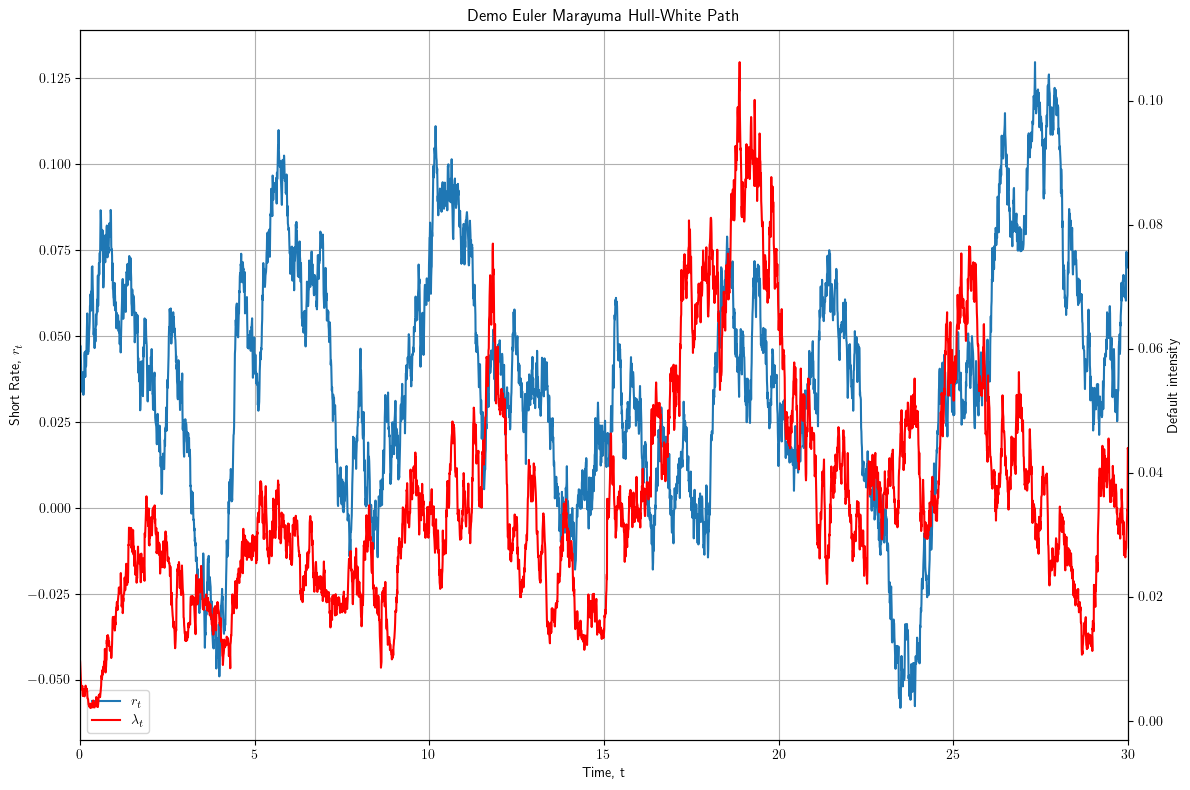

Correlation of output rho = 0: -0.0033814051714546886 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import random
from scipy.stats import norm
import scipy.optimize as optimize
import time
from joblib import Parallel, delayed

plt.rcParams['text.usetex'] = True


# Set parameters, for clarity those related to the JCIR model will be preceded by a J and those related to the Hull white by an H
t0 = 0
T = 30

# Intensity params
lambda0 = 0.01
mu = 0.01
kappa = 1
v = 0.1

j_alpha = T/4 # We should expect to see about 4 jumps,
gamma = mu/5 # With expected size mu/5

# Short rate params
r0 = 0.045
alpha = 1
theta = r0*alpha
sigma = np.sqrt(r0)/5

rand = Generator(PCG64())

## Generate Jumps for the JCIR
jump_times = t0 + (T-t0)*rand.random(rand.poisson(j_alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run rho 0.8 diffusion model for let's say 1280 time steps over our 10 time units, i.e. dt = 1/128
N = T*128
t_s = np.linspace(t0,T,N)
t_s = np.concatenate((t_s,jump_times))
t_s.sort()
Y_s = np.linspace(np.sqrt(lambda0), np.sqrt(lambda0), len(t_s)) 
lambdas = np.linspace(lambda0, lambda0,len(t_s))
r = np.linspace(r0, r0,len(t_s))

# We could (should?) use Cholesky decomposition to covary the noise as well, but since multivariate_normal let's us generate correlated noise why not let it take care of it for us
# for time varying we can generate in the for loop, or predraw all as here, but with varying rho
rho1 = 0
gen_noise = rand.multivariate_normal([0,0],[[1, rho1], [rho1, 1]],(len(t_s)))
Z_gen = gen_noise[:,0]
W_gen = gen_noise[:,1]

for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*W_gen[i]
    dZ = np.sqrt(dt)*Z_gen[i]

    # Generate interest rate
    r[i] = r[i-1] + (theta-alpha*r[i-1])*dt + sigma*dW

    # Generate JCIR 
    lambdas[i] = lambdas[i-1] + kappa*(mu-lambdas[i-1])*dt + v*np.sqrt(lambdas[i-1])*dZ

    # Emergency negative catch
    if lambdas[i] < 0:
        lambdas[i] = 0

    if not not jumps:
        if t_s[i] == jumps[0][0]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            jumps.pop(0)


    

fig1, ax1 = plt.subplots(figsize = (12,8), tight_layout = True)
p1 = ax1.plot(t_s,r,label = r"$r_t$")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s, lambdas, label = r"$\lambda_t$", color = "red")
ax2.set_ylabel("Default intensity")
ax1.set_title("Demo Euler Marayuma Hull-White Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Short Rate, $r_t$")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend(handles= p1+p2, loc = "lower left")
plt.show()
print(r"Correlation of output rho = %s" %(rho1) + ": %s " %(np.corrcoef((lambdas,r))[0][1]))

### Pricing Swaptions Semi-Analytically
What is written below is based almost entirely on the Lecture slides created by [Grezlak](https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/tree/main), specifically lectures 4, 5 and 7. (We have this in the projektplan)

We're operating under the Hull-White model 
$$dr_t = (\theta - \alpha r_t)dt + \sigma_t dW_t$$
assuming constant variance $\sigma$ (to begin with) we can price the European Swaption with nominal N using European puts on ZCB:s (Magnus Slides)
$$N\sum_{k = m+1}^{n}c_kV_{T_m,T_k}^{\mathrm{ZCB}}(t_0,\hat{K},-1)$$
with
$$\hat{K} = e^{A + B\cdot r^*}$$
and $c_k$, $r^*$ chosen such that
$$1 - \sum_{k = m+1}^{n}c_k \mathrm{exp}\left(A(T_m,T_k) + B(T_m,T_k)r^*\right) = 0 \\
c_k = K \tau_k ~ \forall (k \in \{m+1,...,n-1\}) \\
c_n = K(1 + \tau_n)$$
and the functions + price of ZCB
$$A(t,T) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (T-t)} - 4e^{-\alpha (T-t)} - 2\alpha (T-t) \right) + \alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz$$
$$B(t,T) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(T-t)} \right) $$
$$P(t,T) = \mathrm{exp}(A(t,T) + B(t,T)r(t)) $$
we can solve the integral analytically for fixed $\alpha$ and $\theta$
$$\alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz = -\frac{\theta}{\alpha}\int_{t}^{T}1 - e^{-\alpha T} e^{\alpha z}dz \\
= -\frac{\theta}{\alpha}[z - \frac{1}{\alpha}e^{-\alpha T}e^{\alpha z}]_{t}^{T} = -\frac{\theta}{\alpha}\left((T-t) - \frac{1}{\alpha}(1 - e^{-\alpha(T - t)})\right)$$
So we can rephrase $A(t,T) = [\tau = T - t] = A(\tau)$ and $B(t,T) = B(\tau)$ as
$$A(\tau) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (\tau)} - 4e^{-\alpha (\tau)} - 2\alpha (\tau) \right) - \frac{\theta}{\alpha}\left((\tau) - \frac{1}{\alpha}(1 - e^{-\alpha(\tau)})\right)$$
$$B(\tau) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(\tau)} \right)$$


#### Pricing ZCB put
We can price the ZCB put option as 
$$V_c^{\mathrm{ZCB}}(t_0,T) = P(t_0,T) e^{A(\tau)}\left[\mathrm{exp}(\frac{1}{2}B(\tau)^2v_r^2(t_0,T) + B(\tau)\mu_r(t_0,T))\mathit{F}_{\mathcal{N}(0,1)}(\mathit{d_1}) - \hat{K}_2\mathit{F}_{\mathcal{N}(0,1)}(d_2) \right]\\
d_1 = a - B(\tau)v_r(t_0,T),~~d_2 = d_1 + B(\tau)v_r(t_0,T), ~~ \hat{K}_2 = Ke^{-A(\tau)} \\
a = \frac{\mathrm{log}\hat{K}_2 - B(\tau)\mu(t_0,T)}{B(\tau)v_r(t_0,T)} \\
\mu(t_0,T) = r_0e^{-\alpha(T-t_0)} + \alpha\int_{t_0}^T\hat{\theta}(z,T)e^{-\alpha(T-z)}dz \\
= \left[\hat{\theta} = \theta/\alpha + \frac{\sigma^2}{\alpha^2}(e^{-\alpha(T-t)} -1)\right] = r_0e^{-\alpha(T-t_0)} + \int_{t_0}^T(\theta(z,T) + \frac{\sigma^2}{\alpha}(e^{-\alpha(T-)}-1))e^{-\alpha(T-z)}dz\\
= [\theta~\mathrm{ const}] = r_0e^{-\alpha(T-t_0)} + \frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\int_{t_0}^T e^{-2\alpha(T-z)} - e^{-\alpha(T-z)}dz \\
= r_0e^{-\alpha(T-t_0)} - \frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\left(\frac{1}{2\alpha}[e^{-2\alpha(T-z)}]^T_{t_0} - \frac{1}{\alpha}[e^{-\alpha(T-z)}]_{t_0}^T \right) \\
= r_0e^{-\alpha(T-t_0)} - \frac{1}{\alpha}(\frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\left(\frac{1}{2\alpha}(1 - e^{-2\alpha(T-t_0)}) - \frac{1}{\alpha}(1 - e^{-\alpha(T-t_0)}) \right)) \\
 v_r^2(t_0,T) = \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha(T-t_0)})$$

with all this legwork done we have a cumbersome but almost explicit (explicit once you've found $r^*$) expression for the value of an option constant parameter Hull-White.

In [126]:
# General functions
A = lambda t,T: -(sigma**2)/(4*alpha**3) * (3 + np.e**(-2*alpha*(T-t)) - 4*np.e**(-alpha*(T-t)) - 2*alpha*(T-t)) - (theta/alpha)*((T-t) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
B = lambda t,T: -(1/alpha)*(1 - np.e**(-alpha*(T-t)))
Khat = lambda t,T, rstar: np.e**(A(t,T) + B(t,T)*rstar)
P = lambda t,T,rt: np.e**(A(t,T)+B(t,T)*rt)

# Put on ZCB functions
Fn = lambda arg: norm.cdf(arg)
mu_v = lambda t, T, r0: r0*np.e**(-alpha*(T - t)) + (theta/alpha)*(1 - np.e**(-alpha*(T - t))) + (sigma**2)*(1/alpha)*((1/(2*alpha))*(1 - np.e**(-2*alpha*(T-t))) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
v_r2 = lambda t,T: (sigma**2)/(2*alpha)*(1 - np.e**(-2*alpha*(T-t)))
B_bar = lambda tau: B(0,tau) # This only works since theta constant otherwise this would need t dependence
A_bar = lambda tau: A(0,tau) # --||--
Khat2 = lambda tau, K: K*np.e**(-A_bar(tau))
a = lambda t,T,tau,K, r0: (np.log(Khat2(tau,K)) - B_bar(tau)*mu_v(t,T,r0))/(B_bar(tau)*(v_r2(t,T))**(1/2))

d1 = lambda t,T,tau,K,r0: a(t,T,tau,K,r0) - B_bar(tau)*(v_r2(t,T)**(1/2))
d2 = lambda t,T,tau,K,r0: d1(t,T,tau,K,r0) + B_bar(tau)*(v_r2(t,T)**(1/2))

# Value of a put option on a ZCB, option expiry T before or at payout date of ZCB T + tau, for call pass type = 0 for put type = 1
def VZCB(t,T,tau,K,rt, type):
    term1 =  np.exp((0.5*B_bar(tau)**2*v_r2(t,T) + B_bar(tau)*mu_v(t,T,rt)))*Fn(d1(t,T,tau,K,rt)) - Khat2(tau,K)*Fn(d2(t,T,tau,K,rt))
    call_value = P(t,T,rt)*np.exp(A_bar(tau))*term1 
    return call_value + type*(-P(t,T+tau,rt) + K*P(t,T,rt))
# c_k from schedule
cashflows = lambda K, Ts: (K*np.diff(Ts) + np.concatenate((np.zeros((1,len(Ts)-2)), np.asmatrix(1)),1)).A1

# Solve for rstar
minimize = lambda cashflows, dates, Tm, rstar: 1 - sum([c*np.e**(A(Tm,date) + B(Tm,date)*rstar) for c, date in zip(cashflows,dates)])
def rstar(cashflows, dates, Tm):
    optim = lambda rstarl: minimize(cashflows, dates, Tm, rstarl)
    return optimize.newton(optim, 0)

# Solve for swap price, dealing with if a swap is already entered / payments have already been made
def swap_price(t,rt,T_s, K):
    # Catch passed swap
    if T_s[-1] <= t:
        return 0
    
    T_s = T_s.copy()

    # Strip away all but the first passed time, such that only future payments, and the last reset remain
    T_s = np.append(T_s,np.inf)
    T_s = [T_s[i] for i in np.arange(0,len(T_s)-1) if T_s[i+1] > t]

   
    # Locked in portion, ie. if we are in the first swap bucket after the strip above
    set_payment_value = 0
    interest_rate_locked = 0
    if t > T_s[0] and not len(T_s) <= 1:
        fix_date = T_s[0]
        payment_date = T_s[1]
        tau = payment_date - fix_date
        interest_rate_locked = r[min(range(len(t_s)), key=lambda i: abs(t_s[i]-fix_date))] # This search is massively slowing down the process, we need an interpolated interest rate function
                                                                                                    # ALso since i'm now checking backward in time for the interest rates I might as well just have t since we're using rt anyways, or split into theoretical vs market or smth
        set_payment_value = tau*(interest_rate_locked - K)*P(t,payment_date,rt)
        T_s = T_s[1:]

    # Future portion
    future_value = 0
    if not len(T_s) <= 1:
        future_value = P(t,T_s[0],rt) - P(t,T_s[-1],rt) - K*sum([tau_k*P(t,T_k,rt) for tau_k, T_k in zip(np.diff(T_s),T_s[1:])])

    return (future_value + set_payment_value)

# Solve for Payer Swaption (Get floating pay fixed)with nominal 1
def swaption_price(t, rt, T_s, K):
    T_m = T_s[0] # The entrance date
    if (t>T_m or len(T_s)<2): # If the expiry has passed your swaption should be worthless / Expired
        value = 0 
        return value

    # Otherwise we use the formula as written
    dates = T_s[1:] # The payment dates
    cashs = cashflows(K, T_s) # The Cashflows

    rst = rstar(cashs, dates, T_m) # Rstar
    value = (sum([c*VZCB(t, T_m, Tk-T_m, Khat(T_m,Tk,rst), rt, 1) for c, Tk in list(zip(cashs,dates))]))
    return value

def caplet_price(t, rt,T_m,T_n,K):
    value = 0
    # First we check if the caplet is already locked in 
    if T_m <= t:
        idx_T_0 = len(t_s[t_s<T_m])
        r_0 = r[idx_T_0]
        valueatexpiry = max((0,(r_0-K)))
        value =  (P(t,T_n,rt)*valueatexpiry)
    # Otherwise use caplet formula for HW model see page 76 of Interest rate models by Brigo
    else:
        sigma_p = lambda t,T: sigma*np.sqrt((1 - np.exp(-2*alpha*(T - t)))/(2*alpha))*P(t,T,rt)
        h = lambda t,T,S,X: (1/sigma_p(t,T))*np.log((P(t,S,rt))/(P(t,T,rt)*X)) + sigma_p(t,T)/2
        ZPB = lambda t,T,S,X: X*P(t,T,rt)*norm.cdf(-h(t,T,S,X) + sigma_p(t,T)) - P(t,S,rt)*norm.cdf(-h(t,T,S,X))

        X = 1/(1 + K*(T_n-T_m))
        value = (1 + K*(T_n-T_m))*ZPB(t,T_m,T_n,X)

    return value
    


Swaption value at time t = 0.0: [0.00750107]


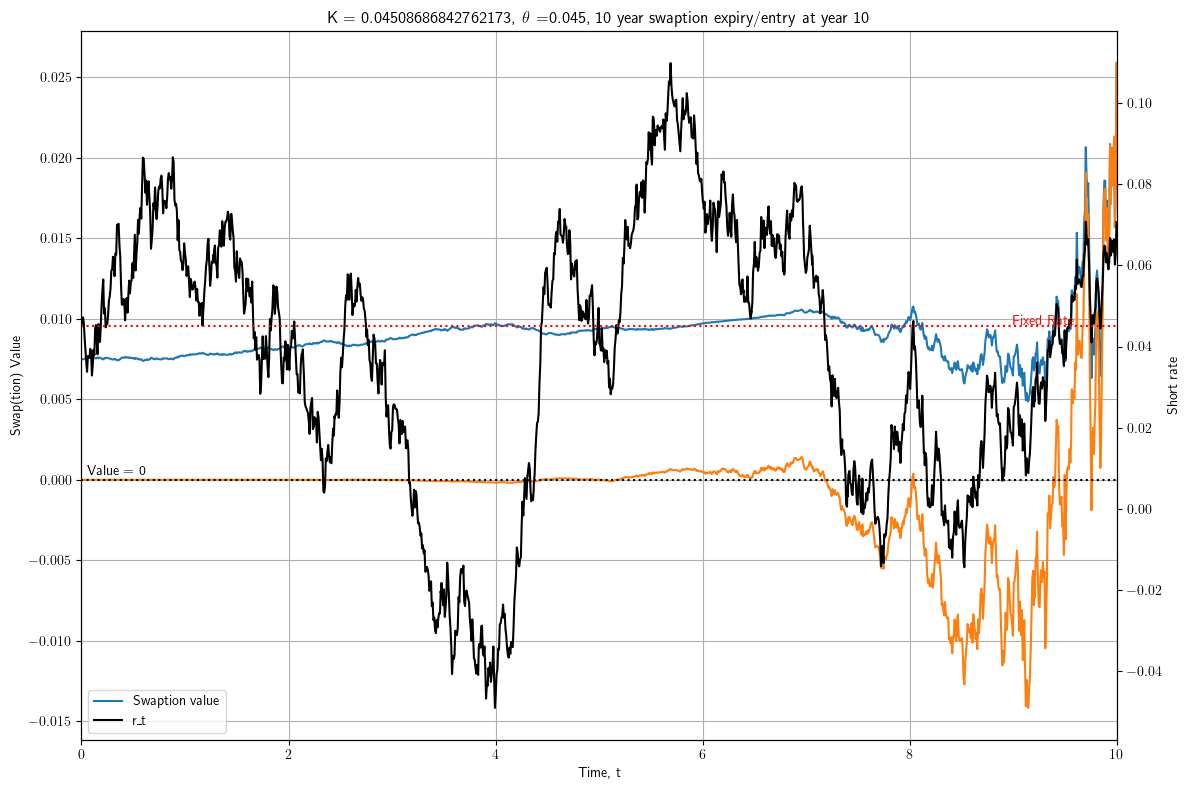

In [3]:
# Looking good
T_s = np.arange(10,21,1)
K = (P(0,T_s[0],r0) - P(0,T_s[-1],r0))/(sum([P(0,T_s[i],r0) for i in range(1,len(T_s))]))
swap_prices = np.zeros((len(t_s[t_s < 10]),1))
swapt_prices = np.zeros((len(t_s[t_s < 10]),1))

for i in np.arange(0,len(t_s[t_s < 10])):
    swapt_prices[i] = swaption_price(t_s[i],r[i], T_s, K)
    swap_prices[i] = swap_price(t_s[i],r[i],T_s,K)
    
print("Swaption value at time t = %s: %s" %(t_s[0], swapt_prices[0]))

fig1, ax1 = plt.subplots(figsize = (12,8), tight_layout = True)
p1 = ax1.plot(t_s[t_s <= 10],swapt_prices,label = "Swaption value")
p1p = ax1.plot(t_s[t_s <= 10],swap_prices,label = "Swap value")
ax1.set_title(r"K = %s, $\theta$ =%s,   10 year swaption expiry/entry at year 10" %(K,theta))
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Swap(tion) Value")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s[t_s <= 10], r[t_s <= 10], label = r"r_t", color = "black")
h1 = ax2.hlines(K,xmin= 0, xmax=10, label="Strike", linestyles=":",colors="red")
h2 = ax1.hlines(0,xmin= 0, xmax=10, label="Value = 0", linestyles=":",colors="black")
ax2.set_ylabel("Short rate")
ax1.set_xlim((t0,10))
ax1.grid(True)
ax2.text(9, K + 0.001, s= "Fixed Rate", ha = 'left', va = 'center', color = 'red')
ax1.text(0.05, 0 + 0.0005, s= "Value = 0", ha = 'left', va = 'center', color = 'black')
ax2.legend(handles=p1+p2, loc = "lower left")
plt.show()


### Yield Curve

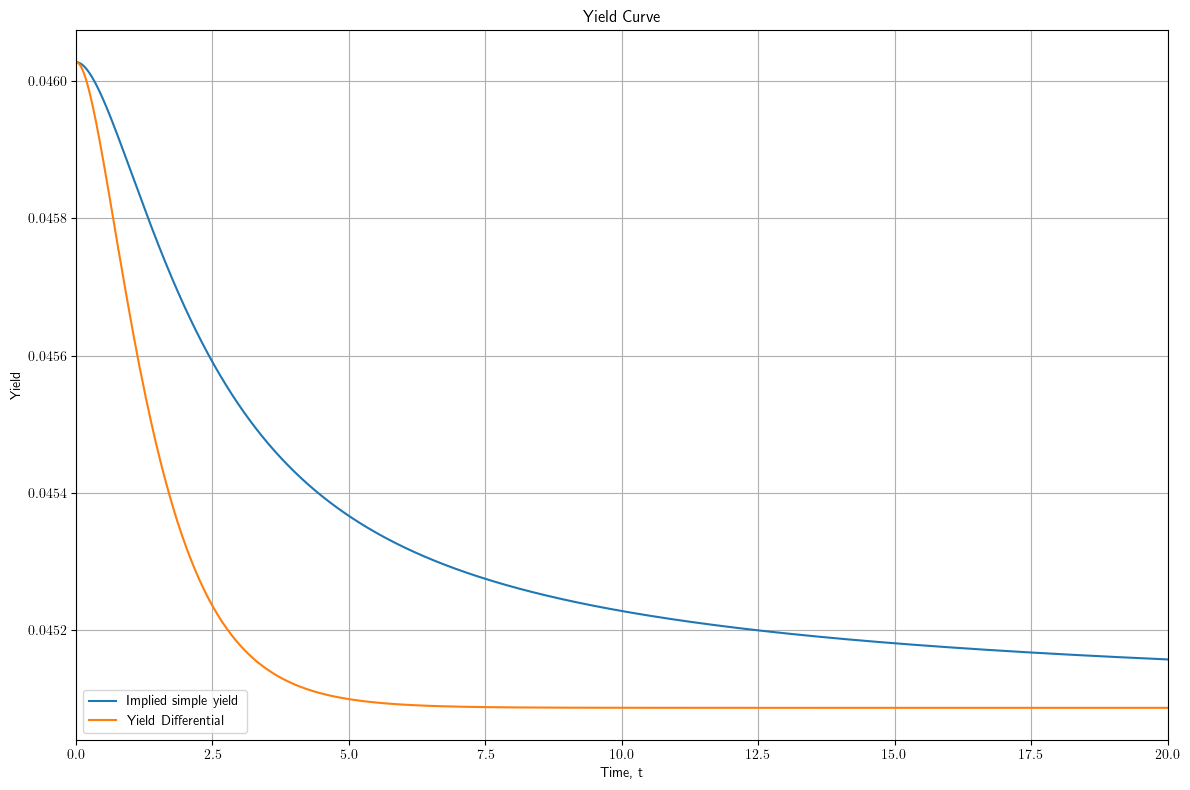

In [4]:
# The yield curve is given by P(0,T)^(-1/t) - 1
yield_curve = [P(0,t_s[i],r0)**(-1/(t_s[i])) - 1 for i in range(1,len(t_s))]
yield_curve_diff = [np.exp(-np.log((P(0,t_s[i],r0)/P(0,t_s[i-1],r0)))/(t_s[i] - t_s[i-1]))-1 for i in range(1,len(t_s))]

fig1, ax1 = plt.subplots(figsize = (12,8), tight_layout = True)
p1 = ax1.plot(t_s[1:],yield_curve,label = "Implied simple yield")
p2 = ax1.plot(t_s[1:],yield_curve_diff,label = "Yield Differential")
ax1.set_title("Yield Curve")
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Yield")
ax1.set_xlim((t0,20))
ax1.grid(True)
ax1.legend(handles=p1+p2, loc = "lower left")
#ax1.set_ylim(bottom = 0)
plt.show()


### Monte Carlo
TODO: Improve explanation

$\mathbb{E}[e^{-\int_t^T r_t}X(r_T)| \mathcal{F}_t] \approx \frac{1}{N}\sum_{i=1}^N e^{-\int_t^T \hat{r}_s ds}X(\hat{r}_T)$ so long as $\hat{r}_T$ and $e^{-\int_t^T \hat{r}_s ds}$ are drawn correctly.

### Demonstration/Clarification of how Monte Carlo Loop works using t = 0 as an example, single point pricing with no variance reduction techniques

In [5]:
# Set up the Swap params
K = (P(0,T_s[0],r0) - P(0,T_s[-1],r0))/(sum([P(0,T_s[i],r0) for i in range(1,len(T_s))]))
T_s = np.arange(10,21,1)
T = T_s[0]
durations = np.diff(T_s)
payment_dates = T_s[1:]

# Set up pricing known good mean/var functions for r to check against 
mu_hat = lambda T, t, rt: np.e**(-alpha*(T - t))*rt + (theta/alpha)*(1- np.e**(-alpha*(T-t)))
sigma_hat_2 = lambda T, t: (sigma**2/(2*alpha))*(1 - np.e**(-2*alpha*(T-t)))

# Set a high number of samples since we're only running a point
N_samples = 10000

# Find future HullWhite market state distribution
# We as in Ostrovski(1) split r(t) into x(t) + beta(t)
# We treat our current time as t = 0 and the end time as being T, ie s=0 .
t_proxy = T

# The random variable x has a clearly given set of equations for its expectation, and variance and the same for it's integral
x_0 = 0 # by defnition
E_x = 0 # Since x_0 is 0
E_int_x = 0 # Since x_0 is 0
var_x = (sigma**2)/(2*alpha)*(1 - np.e**(-2*alpha*t_proxy))
var_int_x = (sigma**2)/(alpha**2)*(t_proxy + (2/alpha)*np.e**(-alpha*(t_proxy)) - (1/(2*alpha))*np.e**(-2*alpha*t_proxy) - (3/(2*alpha)))
cov_xs = ((sigma**2)/(2*alpha**2)) * (1 - np.e**(-alpha*(t_proxy)))**2

# For beta however they use the market price of ZCBs, much like Grezlek, since we have the analytic equation for ZCBs we can find f exactly
#P(0,t,r0) = np.e**(A(0,t)+B(0,t)*r0)
#->f(0,t) = - d/dt log(P) = - d/dt (A(0,t)+B(0,t)*r0) = -(d/dt A(0,t) + r0*d/dt(B(0,t)))
#d/dt A(0,t)  = -sigma^2/4*alpha^2 * (-2e^(-2alpha * t) + 4e^(-alpha*t) - 2) - (theta/alpha)(1 - e^(-alpha*t))
#d/dt(B(0,t)) = -e^(-alpha*t)
f = -((-sigma**2/alpha**2)*(-2*np.e**(-2*alpha*t_proxy) + 4*np.e**(-alpha*t_proxy) - 2) - (theta/alpha)*(1 - np.e**(-alpha*t_proxy)) - r0*np.e**(-alpha*t_proxy))
eps = 1e-6
f_approx = -(np.log(P(0,t_proxy + eps,r0)) - np.log(P(0,t_proxy,r0)))/(eps)


# And we can check our work with their method for say T_i+1 = T + 0.001, T_i = T
print("--- Diagnostics for f ---")
print("Analytic f: %s" %f)
print("Approx f: %s" %f_approx)
print("So my analytic f is wrong, let's use the approx")

f = f_approx

beta = f + sigma**2/(2*alpha**2)*(1 - np.e**(-alpha*t_proxy))**2
beta_int = -np.log(P(0,t_proxy,r0)) + (sigma**2/(2*alpha**2))*((2/alpha)*np.exp(-alpha*t_proxy) + t_proxy - (1/(2*alpha))*np.exp(-2*alpha*t_proxy) - (3/(2*alpha)))

# Now we have expectations and covariances for the random variables so we can x(t) and add it to beta(t) to generate r(t), and find e^(-\int_0^t r(s)ds) by estimating the integral as beta_int + x_int by the linearity of integration
mkt_samples = rand.multivariate_normal([E_x,E_int_x],[[var_x, cov_xs],[cov_xs,var_int_x]], N_samples, method = "cholesky")
res_r = mkt_samples[:,0] + beta # Samples of r
res_discount = np.exp(-(mkt_samples[:,1] + beta_int)) # Samples of e^(-r)

# We can check that the expectation of r should be mu_hat, with variance sigma_hat_2, and the expecatation of the discount should be the ZCB price
print()
print(r"--- Diagnostics for $r$ and $e^{-\int_0^t r(s) ds}$ ---")
print("Analytic E[r]: %s" %mu_hat(T,0,r0))
print("Approx   E[r]: %s" %np.mean(res_r))
print("Analytic Var(r): %s" %sigma_hat_2(T,0))
print("Approx   Var(r): %s" %np.var(mkt_samples[:,0],ddof=1))
print("Analytic P(t,T): %s" %P(0,T,r0))
print("Approx   P(t,T): %s" %np.mean(res_discount))

# Now we can generate our Swaptions from the fact that V(Swaption_expiry) = V(Swap_expriy)^+
swap_samples = [swap_price(T,x, T_s, K) for x in res_r]
swaption_samples = [x*(x>0) for x in swap_samples]

# And find the relevant expectation as a sum, + bootstrap variance of expectation
discounted_samples = [val*discount for val, discount in zip(swaption_samples, res_discount)]
val = np.mean(discounted_samples)
std_dev = np.sqrt(np.var(discounted_samples, ddof = 1)/N_samples)

print()
print("*--- Resulting Values ---*")
print("Analytic value of swaption at t = 0: %s" %np.squeeze(swapt_prices[0]))
print("Estimated value of swaption at t = 0: %s" %val)
print("Estimated std deviation of estimate: %s" %std_dev)


# Ostrovski (1) Vladimir Ostrovski: EFFICIENT AND EXACT SIMULATION OF THE HULL-WHITE MODEL, published 2013, SSRN ID 2304848, url:https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2304848

--- Diagnostics for f ---
Analytic f: 0.041400326872074136
Approx f: 0.04410008175304014
So my analytic f is wrong, let's use the approx

--- Diagnostics for $r$ and $e^{-\int_0^t r(s) ds}$ ---
Analytic E[r]: 0.045
Approx   E[r]: 0.04466423390197505
Analytic Var(r): 0.0008999999981449618
Approx   Var(r): 0.0008846078664765122
Analytic P(t,T): 0.6425247649533888
Approx   P(t,T): 0.642202548973129

*--- Resulting Values ---*
Analytic value of swaption at t = 0: 0.007501068435331768
Estimated value of swaption at t = 0: 0.007326547217799549
Estimated std deviation of estimate: 0.00010434984852272539


In [67]:
### TODO I need to add variance reduction :)
### TODO I need to standardize coloring in plots, the legends give all you need but they're confusing enough as is without me swapping colors between short rate and swaption value halfway through
## TODO Fix the analytic f

### For all time points produced by a run of the interest rate model


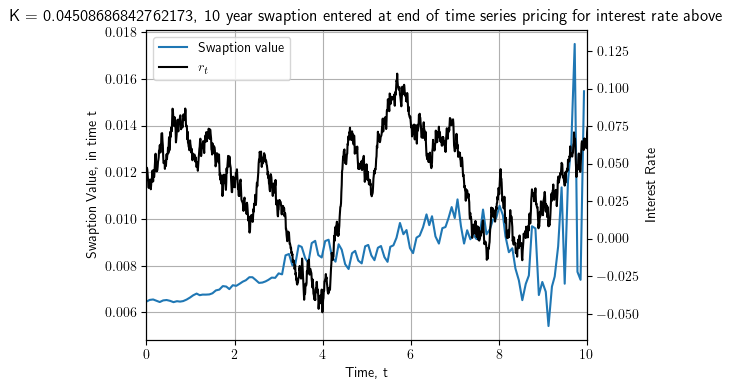

In [6]:
# Set up the Swap params
K = (P(0,T_s[0],r0) - P(0,T_s[-1],r0))/(sum([P(0,T_s[i],r0) for i in range(1,len(T_s))]))
T_s = np.arange(10,21,1)
T = T_s[0]
durations = np.diff(T_s)
payment_dates = T_s[1:]

# Set up pricing and mean/var functions for r to check against 
mu_hat = lambda T, t, rt: np.e**(-alpha*(T - t))*rt + (theta/alpha)*(1- np.e**(-alpha*(T-t)))
sigma_hat_2 = lambda T, t: (sigma**2 /2*alpha)*(1 - np.e**(-2*alpha*(T-t)))

# Prep lists for results
end_val = np.zeros((len(t_s),1))
init_val = end_val
local_val = end_val

# Slightly lower sample count, it's noisier but runtime demands it, once I add var reduction techniques it should be fine?
N_samples = 200

# Run (Parallelized since there's no cross talk, we could parallelize lower level stuff but I think it's more intuitive to do it at as a high a level as possible)
# I also just chose the seemingly simplest way to parallelize from the first thread I  found, but it seems to work? https://stackoverflow.com/questions/9786102/how-do-i-parallelize-a-simple-python-loop
def process(i):
    # Get Time and interest rate
    curr_t = t_s[i]
    curr_r = r[i]

    # Find future HullWhite market state distribution
    # We as in Ostrovski(1) split r(t) into x(t) + beta(t)
    # We treat our current time as t = 0 and the end time as being T.
    t_proxy = T - curr_t

    x_0 = 0 # by defnition
    E_x = 0 # Since x_0 is 0
    E_int_x = 0 # Since x_0 is 0
    var_x = sigma**2/(2*alpha) * (1 - np.e**(-2*alpha*t_proxy))
    var_int_x = (sigma**2)/(alpha**2)*(t_proxy + (2/alpha)*np.e**(-alpha*(t_proxy)) - (1/(2*alpha))*np.e**(-2*alpha*t_proxy) - (3/(2*alpha)))
    cov_xs = ((sigma**2)/(2*alpha**2)) * (1 - np.e**(-alpha*(t_proxy)))**2

    eps = 1e-5
    f = -(np.log(P(0,t_proxy + eps,curr_r)) - np.log(P(0,t_proxy,curr_r)))/(eps)
    beta = f + sigma**2/(2*alpha**2)*(1 - np.e**(-alpha*t_proxy))**2
    beta_int = -np.log(P(0,t_proxy,curr_r)) + (sigma**2/(2*alpha**2))*((2/alpha)*np.exp(-alpha*t_proxy) + t_proxy - (1/(2*alpha))*np.exp(-2*alpha*t_proxy) - (3/(2*alpha)))
    mkt_samples = rand.multivariate_normal([E_x,E_int_x],[[var_x, cov_xs],[cov_xs,var_int_x]], N_samples)
    res_r = mkt_samples[:,0] + beta
    res_discount = np.exp(-(mkt_samples[:,1] + beta_int))

    swap_samples = [swap_price(T,x, T_s, K) for x in res_r]
    swaption_samples = [x*(x>0) for x in swap_samples]

    discounted_swaption_samples = [disc*val for disc, val in zip(res_discount,swaption_samples)]
    val = np.mean(discounted_swaption_samples)
    return val

# I set njobs to 4 since I have an old cpu from before thread count was the big thing, you might be able to get better results turning that up or down, it only generates values for 1 in every (step) points, this is to make generation faster
i_val = np.arange(len(r[t_s<10]), step=10)
val = Parallel(n_jobs = 4)(delayed(process)(i) for  i in i_val)
t_val = t_s[i_val]


# Just plotting stuff, the plot looks ugly :/
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
p1 = ax1.plot(t_val,val,label = "Swaption value")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s,r,label = r"$r_t$", color = "black")
ax2.set_ylabel("Interest Rate")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %K)
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Swaption Value, in time t")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend(handles=p1+p2)
plt.show()

# Ostrovski (1) Vladimir Ostrovski: EFFICIENT AND EXACT SIMULATION OF THE HULL-WHITE MODEL, published 2013, SSRN ID 2304848, url:https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2304848

##### A comment on the results above
There is a bias and sometimes a breakpoint visible in the results, these might be possible to reduce through var reduction, but the bias might sitck around depending on cause., and fall as the number of samples rises, at for instance N_samples = 100000 the process behaves perfectly, but this takes 8 minutes even at the reduced timestep.

### Finding Q from gamma
Given that we are using JCIR as presented in Brigos book on CVA we have a closed form solution for the probability of default by T. 
$$\mathbb{Q}(\tau > T) = 1_{\tau > t}\hat{\alpha}(t,T)\mathrm{exp}(-\hat{\beta}(t,T)\lambda_t)$$
$$d \lambda_t = \kappa(\mu_\lambda - \lambda_t) dt + v_\lambda\sqrt{\lambda_t}dZ_t + dJ_t ^{\alpha, \gamma} $$
$$\hat{\alpha}(t,T) = A_{\mathrm{CIR}}(t,T)\left(\frac{2h \mathrm{exp}(\frac{h + \kappa + 2\gamma}{2}(T-t))}{2h + (\kappa + h + 2\gamma)(\mathrm{exp}(h(T-t)) -1)} \right)^{\frac{2\alpha \gamma}{v^2 - 2\kappa \gamma - 2\gamma^2}}$$
$$\hat{\beta}(t,T) = B(t,T) $$
$$A_{\mathrm{CIR}}(t,T) = \left[\frac{2h\mathrm{exp}\{(\kappa+h)(T-t)/2\}}{2h + (\kappa + h)(\mathrm{exp}\left\{(T-t)h\right\} -1)}\right]^{2\kappa\mu/\sigma^2}$$
$$B_{\mathrm{CIR}}(t,T) = \frac{2(\mathrm{exp}\{(T-t)h\}-1)}{2h + (\kappa+h)(\mathrm{exp}\{(T-t)h\}-1)}$$
$$h = \sqrt{\kappa^2 + 2v^2}$$

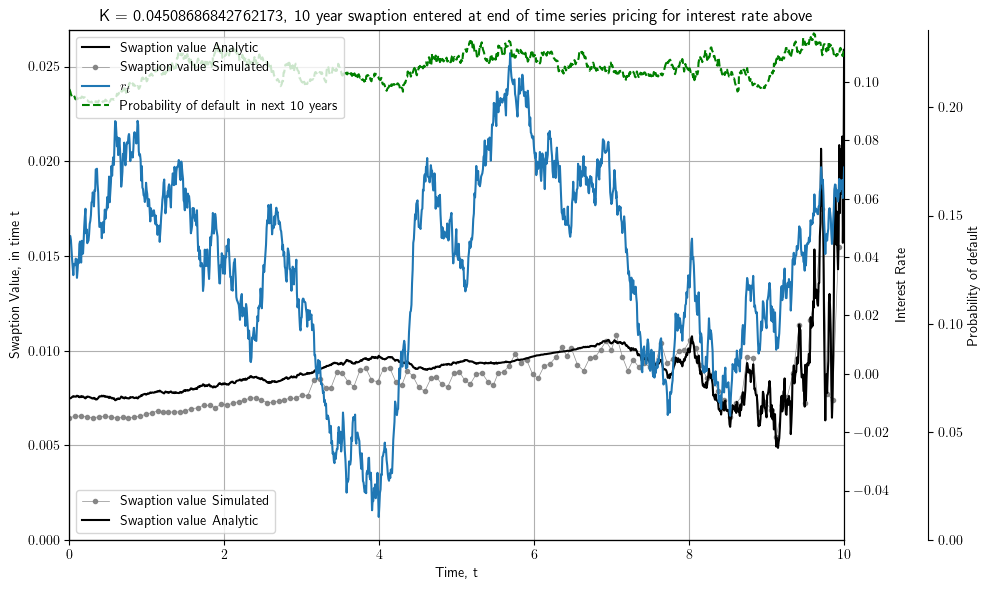

In [7]:
# Defining functions bottom up
h = (kappa**2 + 2*v**2)**(1/2)
B_cir = lambda t,T: (2*(np.exp((T-t)*h)-1))/(2*h + (kappa + h)*(np.exp((T-t)*h)-1))
A_cir = lambda t,T: ((2*h*np.exp((kappa + h)*(T - t)/2))/(2*h + (kappa + h)*(np.exp((T-t)*h) -1)))**(2*kappa*mu/(v**2))
beta_hat = lambda t,T: B_cir(t,T)
alpha_hat = lambda t,T: A_cir(t,T)*((2*h*np.exp((h + kappa + 2*gamma)/(2) * (T-t)))/(2*h + (kappa + h + 2*gamma)*(np.exp(h*(T-t))-1)))**((2*j_alpha*gamma)/(v**2 - 2*kappa*gamma - 2*gamma**2))
Q = lambda t,T,lambd: alpha_hat(t,T)*np.exp(-beta_hat(t,T)*lambd) *(T>t) + (t>=T)

# Find for instance Q(tau > T), ie the probability that we get to t = 10 at least
def_by_10 = np.linspace(0, 0,len(t_s[t_s<10]))
def_by_20 = np.linspace(0, 0,len(t_s[t_s<10]))
def_in_next_10 = np.linspace(0, 0,len(t_s[t_s<10]))
for i in np.arange(0,len(t_s[t_s<10])):
    def_by_10[i] = Q(t_s[i], 10, lambdas[i])
    def_by_20[i] = Q(t_s[i], 20, lambdas[i])
    def_in_next_10[i] = Q(t_s[i], 10 + t_s[i], lambdas[i])

# Make a plot with the interest rate, default probability by T = 10 and the Swaption value all plotted together
# Just plotting stuff, the plot looks ugly :/
fig1, ax1 = plt.subplots(figsize = (10,6), tight_layout = True)
p1 = ax1.plot(t_val,val,label = "Swaption value Simulated", color = "grey", marker = 'o',linewidth = 0.5,markersize = 3, alpha = 0.9)
p1p = ax1.plot(t_s[t_s<10],swapt_prices,label = "Swaption value Analytic", color = "black")
ax2 = ax1.twinx()
ax3 = ax1.twinx()
p3 = None#ax3.plot(t_s, 1-def_by_10, label = r"Probability of default by $T_m = 10$" ,color = "red", linestyle = "--")
p4 = None#ax3.plot(t_s, 1-def_by_20, label = r"Probability of default by $T_n = 20$" ,color = "orange", linestyle = "--")
p5 = ax3.plot(t_s[t_s<10], 1-def_in_next_10, label = "Probability of default in next 10 years" ,color = "green", linestyle = "--")
a3upper = ax3.get_ylim()[1]
ax3.set_ylim((0, a3upper))
p2 = ax2.plot(t_s[t_s<10],r[t_s<10],label = r"$r_t$")
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel("Probability of default")
ax2.set_ylabel("Interest Rate")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %K)
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Swaption Value, in time t")
a1upper = ax1.get_ylim()[1]
ax1.set_ylim((0, a1upper))
ax1.set_xlim((t0,10))
ax1.grid(True)
#ax3.legend(handles=p1p + p1+p2+p3+p4+p5,fancybox = True, framealpha = 0.8, loc = "upper left")
ax3.legend(handles=p1p + p1+p2+p5,fancybox = True, framealpha = 0.8, loc = "upper left")
ax1.legend(loc = "lower left")
plt.show()

#print("Correlation of default probability in next 10 years with swaption value: %s" %(np.corrcoef((1-def_in_next_10[i_val],val))[0][1]))



### Simple Pricing CVA from Q and exposure
We can approximate CVA on a Payer IRS with beginning time $T_a$ and end at $T_b$, with payment times $T_i \in {T_{a+1},...,T_{b}}$ as (See Brigo for proof, Osman Sibai for syntax)
$$\mathrm{CVA}_t =  \sum_{i = a+1}^{b-1} PS(t,T_i,T_b,K,S_{T_i,T_b}(t))(\mathbb{Q}(\{\tau>T_{i-1}\}) - \mathbb{Q}\{\tau >T_i\})$$
in our notation, (since $S_{T_i,T_b}$ is baked in to the function/found from r)
$$\mathrm{CVA}_t =  \sum_{i = a+1}^{b-1} PS(t,T_i,T_b,r_t,K)(\mathbb{Q}(\{\tau>T_{i-1}\}) - \mathbb{Q}\{\tau >T_i\})$$


In [80]:
# CVA deserves a full func, since there is some efficiency to be won, and it's both critical and hard to test
def CVA(t, rt, T_s, K, lambd, adj = False):
    # Args:
    # t, the current time/the filtration time
    # rt, the current interest rate
    # T_s, the key dates of the swap
    # K, the fixed leg, you pay diff(T_s)*K as a fixed leg
    # lambd, the current probability of default, the rest of the factors needed to find Q come from the model which Q already "knows"
    # Returns: 
    # The CVA estimate, a float

    # First lets rewrite the T_s vector into a T_s vector where all the payments are actually still in the future, and it starts at the last passed adjustment date
    T_s_local = T_s.copy()
    T_s_local = np.append(T_s_local,np.inf)
    T_s_local = [T_s_local[i] for i in range(len(T_s_local)-1) if T_s_local[i+1] > t]

    # Then we find the probability of default before each payment given that we haven't defaulted up to now, allowing the probability to default in the first bucket to extend to t instead of T
    T_s_proxy = T_s_local.copy()
    if t > T_s_local[0]:
        T_s_proxy = T_s_local[1:]
        T_s_proxy[0] = t
    default_after = [Q(t,T_s_proxy[k],lambd) for k in range(0,len(T_s_proxy),1)]
    default_buckets = [default_after[k-1] - default_after[k] for k in range(1,len(T_s_proxy))]

    # Finding hedging swaptions
    hedging_swaptions = [swaption_price(t,rt, T_s_local[k:], K) for k in range(1,len(T_s_local)-1,1)]

    if adj:
        hedging_swaptions.append(caplet_price(t,rt,T_s_local[0],T_s_local[1],K))
        default_buckets.append(1-Q(t,T_s_local[1],lambd))

    return sum([buc*hedg for buc, hedg in zip(default_buckets,hedging_swaptions)])

In [81]:
# While fixing the default timing as above and suggested by Zhu fixes some issues we are still left with a missing element, see blog https://alluve.wordpress.com/2010/04/10/cva-calculation-example/
def CVA_ub(t, rt, T_s, K, lambd):
    # Args:
    # t, the current time/the filtration time
    # rt, the current interest rate
    # T_s, the key dates of the swap
    # K, the fixed leg, you pay diff(T_s)*K as a fixed leg
    # lambd, the current probability of default, the rest of the factors needed to find Q come from the model which Q already "knows"
    # Returns: 
    # The CVA estimate, a float

    # First lets rewrite the T_s vector into a T_s vector where all the payments are actually still in the future, and it starts at the last passed adjustment date
    T_s_local = T_s.copy()
    T_s_local = np.append(T_s_local,np.inf)
    T_s_local = [T_s_local[i] for i in range(len(T_s_local)-1) if T_s_local[i+1] > t]

    # Then we find the probability of default before each payment given that we haven't defaulted up to now, allowing the probability to default in the first bucket to extend to t instead of T
    T_s_proxy = T_s_local.copy()
    if t > T_s_local[0]:
        T_s_proxy = T_s_local[1:]
        T_s_proxy[0] = t
    default_after = [Q(t,T_s_proxy[k],lambd) for k in range(0,len(T_s_proxy),1)]
    default_buckets = [default_after[k-1] - default_after[k] for k in range(1,len(T_s_proxy))] #Probability of default by future swaption checkpoint

    default_buckets2 = [Q(t,T_s_local[k-1],lambd) - Q(t,T_s_local[k],lambd) for k in range(1,len(T_s_local),1)] # Probability of default by cap payments

    # Finding hedging swaptions
    hedging_swaptions = [swaption_price(t,rt, T_s_local[k:], K) for k in range(1,len(T_s_local),1)]
    # Find hedging caps
    hedging_caplets = [caplet_price(t,rt,T_s_local[k-1],T_s_local[k],K) for k in range(1,len(T_s_local))]


    return (np.sum([buc*hedg for buc, hedg in zip(default_buckets,hedging_swaptions)]) + np.sum([buc*hedg for buc, hedg in zip(default_buckets2,hedging_caplets)]))

In [137]:
def CVA_MC(t,T_s,K,N_samples = 50):
    # We need samples of correctly correlated r_tau, D(0,tau), and swap(tau), so we need to generate time series
    samples = []
    strt_idx = len(t_s[t_s <= t])
    end_idx = len(t_s[t_s < T_s[-1]])

    # Catch final state case 
    if strt_idx >= end_idx-1:
        return 0

    # We can use Control Variates to reduce variance, since we know the expectation of eg r[tau] for every tau, 
    #Expected_r = lambda tau: np.exp(-alpha*tau)*r[strt_idx] + (theta/alpha)*(1 - np.exp(-alpha*tau))
    #r_obs = []
    #r_pred = []
    
    for n in range(0,int(N_samples/2)):
        # Generate noise and fake jumps
        gen_noise_MC = rand.multivariate_normal([0,0],[[1, rho1], [rho1, 1]],(len(t_s) - len(t_s[t_s < t]))) 

        # Antithetic sampling
        for antith in [-1,1]:
            gen_noise_MC = gen_noise_MC*(antith)
            Z_gen = gen_noise_MC[:,0]
            W_gen = gen_noise_MC[:,1]
            jump_times = t0 + (T-t0)*rand.random(rand.poisson(j_alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
            jump_times.sort()
            jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps
            jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities

            # Generate storage vars
            r_MC = r
            lambdas_MC = lambdas
            # Generate Paths
            for i in np.arange(strt_idx,end_idx):
                dt = t_s[i]-t_s[i-1]
                dW = np.sqrt(dt)*W_gen[i-strt_idx]
                dZ = np.sqrt(dt)*Z_gen[i-strt_idx]
                r_MC[i] = r_MC[i-1] + (theta-alpha*r_MC[i-1])*dt + sigma*dW # Generate interest rate
                lambdas_MC[i] = lambdas_MC[i-1] + kappa*(mu-lambdas_MC[i-1])*dt + v*np.sqrt(lambdas_MC[i-1])*dZ # Generate JCIR 
                #Emergency negative catch
                if lambdas_MC[i] < 0:
                    lambdas_MC[i] = 0
                if lambdas_MC[i] > mu*500:
                    lambdas_MC[i] = mu*25
                if np.isnan(lambdas_MC[i]):
                    lambdas_MC[i] = mu
                if not not jumps:
                    if t_s[i] == jumps[0][0]:
                        lambdas_MC[i] = lambdas_MC[i] + jumps[0][1]
                        jumps.pop(0)
            
            # Find default point
            default_idx = int(random.choices(np.arange(strt_idx,end_idx), lambdas_MC[strt_idx:end_idx])[0])
            
            # Find discounts to tau from start
            tot_interest = np.prod((r_MC[strt_idx:default_idx]*(t_s[strt_idx:default_idx]-t_s[strt_idx-1:default_idx-1])+1))

            # Find value of swap at default
            v_swap = swap_price(t_s[default_idx],r_MC[default_idx],T_s,K)

            # Find exposure from swap price
            exposure = max((v_swap,0)) 

            # Discount by known discount factor
            exposure = exposure*(1/tot_interest)      
            
            # Account for MC Selection bias in forcing default        
            sample = exposure*(1-Q(t,t_s[end_idx],lambdas[strt_idx]))
            samples.append(sample)

            # Store end r_s for variance reduction
            #r_obs.append(r_MC[default_idx])
            #r_pred.append(Expected_r(t_s[default_idx]))


    pre_control_variate = np.mean(samples)
    #estimated_corr = np.corrcoef(samples,r_obs)[0,1]
    #estimate = pre_control_variate + estimated_corr*(np.mean(r_obs) - np.mean(r_pred))
    return pre_control_variate

In [138]:
i = 1280
T_s = np.arange(0,11,1)
print("Time is: %s" %t_s[i])
print("Probability of default by t = 1.1: %s" %(1-Q(t_s[i],1.1,lambdas[i])))
print("CVA: %s" %CVA(t_s[i], r[i],T_s,K,lambdas[i]))
print("CVA upper Bound: %s" %CVA_ub(t_s[i], r[i],T_s,K,lambdas[i]))
print("CVA MC: %s" %CVA_MC(t_s[i],T_s,K,100))

Time is: 9.486845532690806
Probability of default by t = 1.1: 0.0
CVA: 0
CVA upper Bound: 5.334668675128252e-05
CVA MC: 5.394343214436853e-05


ValueError: x and y must have same first dimension, but have shapes (90,) and (1350,)

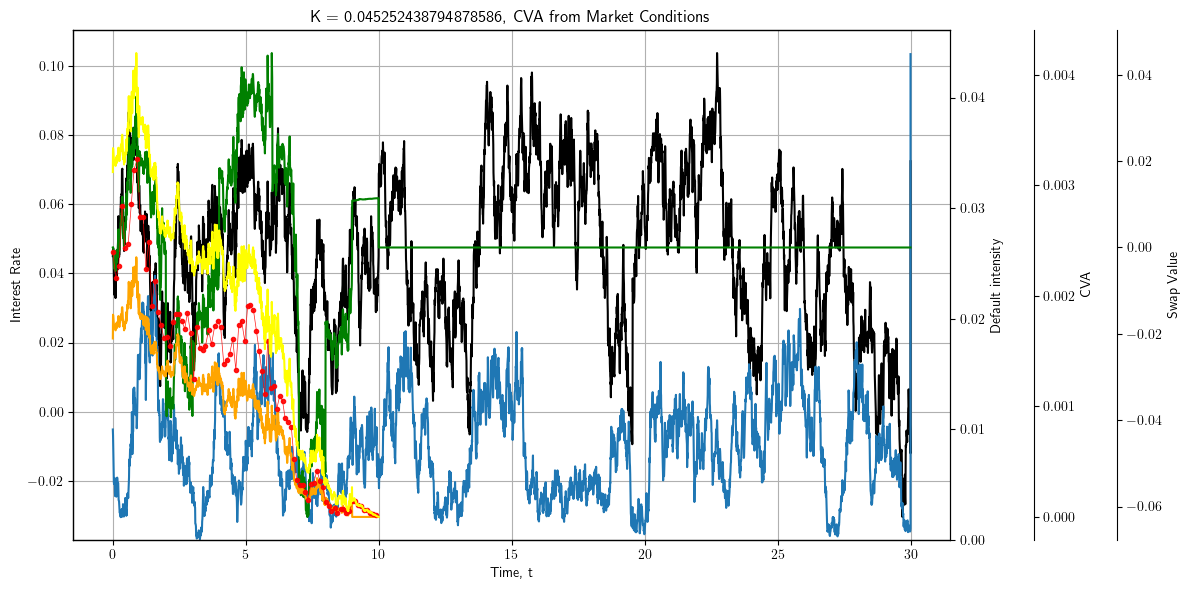

In [ ]:
## Find Delta for CVA (Maybe in Brigo paper)
## Hedge Delta for CVA!
T_s = np.arange(0,11,1)
K = (P(0,T_s[0],r0) - P(0,T_s[-1],r0))/(sum([P(0,T_s[i],r0) for i in range(1,len(T_s))]))

def process(i):
    return CVA(t_s[i], r[i], T_s, K, lambdas[i], adj = False)
i_val = np.arange(len(t_s[t_s <= T_s[-1]]), step=1)
CVA_est = Parallel(n_jobs = 4)(delayed(process)(i) for i in i_val)

def process(i):
    return CVA(t_s[i], r[i], T_s, K, lambdas[i], adj = True)
i_val = np.arange(len(t_s[t_s <= T_s[-1]]), step=1)
CVA_est_c = Parallel(n_jobs = 4)(delayed(process)(i) for i in i_val)


def process(i):
    return CVA_ub(t_s[i], r[i], T_s, K, lambdas[i])
i_val = np.arange(0,len(t_s[t_s <= T_s[-1]]), step=1)
CVA_ub_est = Parallel(n_jobs = 4)(delayed(process)(i) for i in i_val)

N_samples = 1000
def process(i):
    return CVA_MC(t_s[i],T_s,K,N_samples)
i_val_MC = np.arange(0,len(t_s[t_s <= T_s[-1]]), step=15)
#CVA_MC_est = Parallel(n_jobs = 4)(delayed(process)(i) for i in i_val_MC)


fig1, ax1 = plt.subplots(figsize = (12,6), tight_layout = True)
p1 = ax1.plot(t_s,r,label = "Interest Rate", color = "black")
ax1.set_ylabel("Interest Rate")
ax1.set_title("K = %s, CVA from Market Conditions" %K)
ax1.set_xlabel("Time, t")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Default intensity")
p2 = ax2.plot(t_s,lambdas,label = r"$\lambda_t$")
currLim = ax2.get_ylim()
ax2.set_ylim((0,currLim[1]))

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 120))
ax3.set_ylabel("Swap Value")
p3 = ax3.plot(t_s,[swap_price(t,rt,T_s,K) for t,rt in zip(t_s,r)], label = "Swap Value", color = 'green')
currLim = ax3.get_ylim()
#x3.set_ylim((-0.25,0.25))

axC = ax1.twinx()
axC.set_ylabel("CVA")
axC.spines['right'].set_position(('outward', 60))
pc = axC.plot(t_s[i_val],CVA_est,label = "CVA", color = "orange")
pcp = axC.plot(t_s[i_val_MC],CVA_MC_est,label = "CVA With Local Cap, %sk samples"%round(N_samples/1000,1), color = "red",marker = 'o',linewidth = 0.5,markersize = 3, alpha = 0.9)
pcu = axC.plot(t_s[i_val],CVA_ub_est,label = "CVA Upper Bound", color = "yellow")
pcc = axC.plot(t_s[i_val],CVA_est_c,label = "CVA MC, %sk samples"%round(N_samples/1000,1), color = "orange",linestyle = ":")
currLim = axC.get_ylim()
axC.set_ylim((0, currLim[1]))

axC.legend(handles=p1+p2+pc+pcp+pcu+p3+pcc,fancybox = True, framealpha = 0.8, loc = "lower left")

plt.xticks(np.arange(0,21,1))
plt.xlim((0,10))
plt.show()


### Delta Hedging in PS(...) and Q(...)
Expressing the CVA as $$\mathrm{CVA}_t =  \sum_{i = a+1}^{b-1} PS(t,T_i,T_b,r_t,K)(\mathbb{Q}(\{\tau>T_{i-1}\}) - \mathbb{Q}\{\tau >T_i\})$$